In [1]:
'''This Notebook generates Figure 2 for the MIST manuscript
    Also part of the overall flowchart in Figure 1.
    
    NOTE: Please run "Figure 2 more clustering (scanpy).ipynb" 
    first to ge the ScanPy clustering results.
'''
import sys
import pandas as pd
sys.path.append("MIST/")
import neighbors
import utils
import Data
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, rand_score
from tqdm import trange
import warnings
warnings.filterwarnings("ignore")

In [2]:
import scipy
scipy.__version__

'1.6.1'

In [3]:
# read data
melanoma = Data.Data(countpath="data/Melanoma/raw.csv", norm="cpm", radius=1.9)
mouse = Data.Data(countpath="data/MouseWT/raw.csv", norm="cpm", radius=1.9)

In [4]:
# read mouse spot meta data
mouse_meta = pd.read_csv("data/spot_metadata.tsv",sep="\t",index_col=0)

In [5]:
def ARI_score(df):
    """Method to calculate adjusted rand index using sklearn function
        by comparing assigned spatial regions and the annotated meta info.
    """
    mouse_meta = pd.read_csv("data/spot_metadata.tsv",sep="\t",index_col=0)
    mouse_meta = mouse_meta.loc[mouse_meta.Group == "WT_12",:]
    mouse_meta["count_id"] = mouse_meta[["coord_X", "coord_Y"]].apply(lambda x: "x".join(x.astype(str)), axis=1)
    mouse_meta["region"] = mouse_meta["AT"]
    mouse_meta.loc[mouse_meta.Level_01 == "CX","region"] = "CX"
    mouse_meta = mouse_meta[["count_id", "region"]]
    mouse_meta.set_index("count_id", inplace=True, drop=True)
    df = df.loc[df["size"] > 5,:]
    mouse_meta = mouse_meta.loc[df.index,:]
    return adjusted_rand_score(mouse_meta.region.tolist(), df.cluster.tolist())

In [6]:
mousewt_ccs = neighbors.spatialCCs(mouse.nodes, mouse.cormat, 0.7, merge=0)
df = neighbors.assign_membership(mousewt_ccs, mouse.meta)

# Figure 2

### MELANOMA

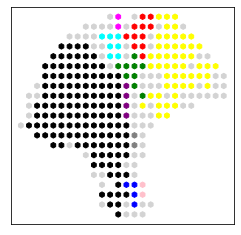

In [7]:
### Regions detected by MIST, Figure 2e
fig4 = plt.figure(figsize=(4,4))
ep = 0.6
mel2_ccs = neighbors.spatialCCs(melanoma.nodes, melanoma.cormat, ep, merge=0)
df = neighbors.assign_membership(mel2_ccs, melanoma.meta)
### The color tuning in the following lines of code won't affect the results
### but to make the visualization colormap similar to the manual annotation
df.loc[df.cluster == "black", "cluster"] = "magenta"
df.loc[df.cluster == "red", "cluster"] = "black"
df.loc[df.cluster == "yellow", "cluster"] = "red"
df.loc[df.cluster == "orange", "cluster"] = "yellow"
df.loc[df["size"] == 1, "cluster"] = "lightgray"
plt.scatter(x=df.y.to_numpy(), y=df.x.to_numpy(), c=df.cluster.tolist(), s=30, marker='h')
plt.xticks([])
plt.yticks([])
fig4.savefig("Fig2_mel_MIST_regions.png", dpi=300, bbox_inches='tight')

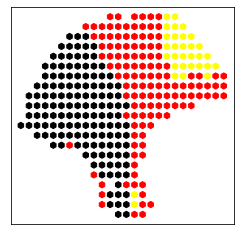

In [8]:
### Regions detected by BayesSpace, Figure 2f
fig5 = plt.figure(figsize=(4, 4))
bs_mel_df = pd.read_csv("BayesSpace_Melanoma_clusters.csv", index_col=0)
color_dict = {1:"red", 2: "black", 3:"yellow"}
# print(set(bs_mel_df['spatial.cluster']))
bs_mel_df['cluster'] = [color_dict[k] for k in bs_mel_df['spatial.cluster']]

plt.scatter(x=bs_mel_df.row.to_numpy(), y=bs_mel_df.col.to_numpy(), 
             c=bs_mel_df['cluster'].tolist(), marker='h', s=40)
plt.xticks([])
plt.yticks([])
fig5.savefig("Fig2_mel_BayesSpace_regions.png", dpi=300, bbox_inches='tight')

{0, 1, 2, 3, 4}


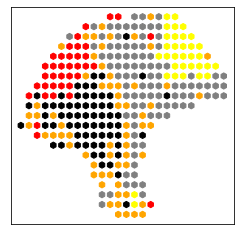

In [9]:
### Clustering results using ScanPy
fig6 = plt.figure(figsize=(4, 4))
sp_mel_df = pd.read_csv("sp_Melanoma_clusters.csv", index_col=0)
color_dict = {0:"gray", 1:"black", 2: "orange", 3:"red", 4:"yellow"}
print(set(sp_mel_df['clusters']))
sp_mel_df['cluster'] = [color_dict[k] for k in sp_mel_df['clusters']]

plt.scatter(x=sp_mel_df.col.to_numpy(), y=sp_mel_df.row.to_numpy(), 
             c=sp_mel_df['cluster'].tolist(), marker='h', s=40)
plt.xticks([])
plt.yticks([])
fig6.savefig("Fig2_mel_ScanPy_regions.png", dpi=300, bbox_inches='tight')

### Mouse sample

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:02<00:00,  1.60it/s]


(0.0, 1.0)

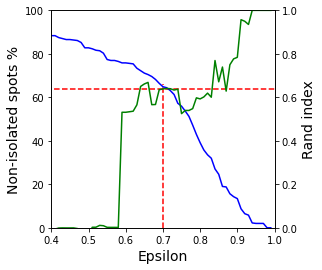

In [10]:
# Figure 2b
cc_explained_mouse, cc_explained_mel2 = [],[]
ari_mouse = []
ranges = np.arange(0,1, 0.01)
for i in trange(len(ranges)):
    ep = ranges[i]
    mousewt_ccs = neighbors.spatialCCs(mouse.nodes, mouse.cormat, ep, merge=0)
    n1 = float(sum([len(cc) for cc in mousewt_ccs if len(cc) > 5]))
    cc_explained_mouse.append(n1/mouse.count.shape[0])
    df = neighbors.assign_membership(mousewt_ccs, mouse.meta)
    ari = ARI_score(df)
    ari_mouse.append(ari)
    mel2_ccs = neighbors.spatialCCs(melanoma.nodes, melanoma.cormat, ep, merge=0)
    n2 = float(sum([len(cc) for cc in mel2_ccs if len(cc) > 5]))
    cc_explained_mel2.append(n2/melanoma.count.shape[0])
    
f = plt.figure(figsize=(4,4))
plt.plot(np.arange(0,1, 0.01), np.multiply(cc_explained_mouse,100), color='blue')
plt.vlines(0.7, ymin=0, ymax=66, color='red', ls = "--")
plt.hlines(64, xmin=0, xmax=60, color='red', ls = "--")

plt.xlabel("Epsilon", fontsize=14)
plt.ylabel("Non-isolated spots %", fontsize=14)
plt.xlim(0.4, 1)
plt.ylim(0, 100)

axs_ari = plt.twinx()
axs_ari.plot(np.arange(0,1, 0.01), ari_mouse, color = "green")
axs_ari.set_ylabel("Rand index", fontsize=14)
axs_ari.set_ylim(0, 1)
#plt.savefig("Fig2_ari_nonisolate_epi.png", dpi=300, bbox_inches='tight')

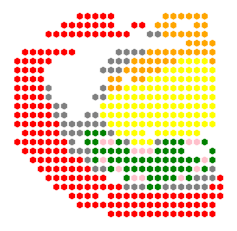

In [11]:
### Mannual annotation, Figure 2a
mouse_annos = mouse_meta.loc[mouse_meta.Group == 'WT_12']
mouse_annos["count_id"] = mouse_annos[["coord_X", "coord_Y"]].apply(lambda x: "x".join(x.astype(str)), axis=1)
mouse_annos["region"] = mouse_annos["AT"]
mouse_annos.loc[mouse_meta.Level_01 == "CX","region"] = "CX";
fig0 = plt.figure(figsize=(4,4))
pal = {"CX": "red", 
       "TH":"yellow", 
       "HY":"orange",
       "HPd":"green",
       "HPs": "pink",
      "FB": "gray"}

sns.scatterplot(data=mouse_annos, x='coord_X', y="coord_Y", 
            hue='region', marker='h', s=60, palette=pal)
plt.gca().invert_yaxis()
plt.legend(bbox_to_anchor=(1.02, 0.8))
plt.legend().remove();
plt.xticks([]);
plt.yticks([]);
plt.xlabel("");
plt.ylabel("");
plt.axis("off");
fig0.savefig("Fig2_mouse_manual_annotations.png", dpi=300, bbox_inches='tight')

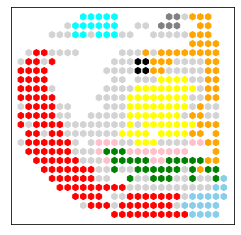

In [12]:
### MIST detected regions, Figure 2c
fig = plt.figure(figsize=(4, 4))
mousewt_ccs = neighbors.spatialCCs(mouse.nodes, mouse.cormat, 0.7, merge=0)
df = neighbors.assign_membership(mousewt_ccs, mouse.meta)
df.loc[df["cluster"] == "purple", "cluster"] ="pink"
df.loc[df["cluster"] == "cyan", "cluster"] ="skyblue"
df.loc[df["cluster"] == "blue", "cluster"] ="cyan"
df.loc[df["cluster"] == "orange", "cluster"] ="magenta"
df.loc[df["cluster"] == "yellow", "cluster"] ="orange"
df.loc[df["cluster"] == "magenta", "cluster"] ="yellow"
plt.scatter(x=df.x.to_numpy(), y=df.y.to_numpy(), 
            c=df.cluster.tolist(), marker='h', s=40)
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
fig.savefig("Fig2_mouse_MIST_regions.png", dpi=300, bbox_inches='tight')

{1, 2, 3, 4, 5, 6, 7}


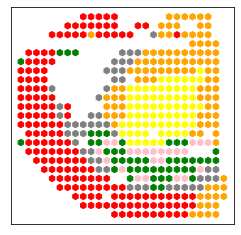

In [13]:
### BayesSpace detected regions
fig2 = plt.figure(figsize=(4, 4))
bs_mouse_df = pd.read_csv("BayesSpace_MouseWT_clusters.csv", index_col=0)
color_dict = {1:"red", 2: "gray", 3:"red",
             4: "orange", 5: "green", 6:"pink", 
              7: "yellow", 8:"lightblue"}
print(set(bs_mouse_df['spatial.cluster']))
bs_mouse_df['cluster'] = [color_dict[k] for k in bs_mouse_df['spatial.cluster']]

plt.scatter(x=bs_mouse_df.col.to_numpy(), y=bs_mouse_df.row.to_numpy(), 
             c=bs_mouse_df['cluster'].tolist(), marker='h', s=40)
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
fig2.savefig("Fig2_mouse_BayesSpace_regions.png", dpi=300, bbox_inches='tight')

{0, 1, 2, 3, 4, 5}


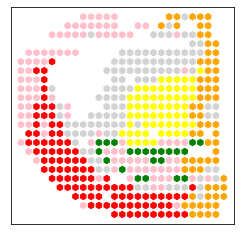

In [15]:
### ScanPy clusters
fig3 = plt.figure(figsize=(4, 4))
sp_mouse_df = pd.read_csv("sp_Mouse_clusters.csv", index_col=0)
color_dict = {1:"pink", 2: "red", 3:"orange",
             4: "yellow", 5: "green", 6:"pink", 
              0:"lightgray"}
print(set(sp_mouse_df['clusters']))
sp_mouse_df['cluster'] = [color_dict[k] for k in sp_mouse_df['clusters']]
plt.scatter(x=sp_mouse_df.row.to_numpy(), y=sp_mouse_df.col.to_numpy(), 
             c=sp_mouse_df['cluster'].tolist(), marker='h', s=40)
plt.gca().invert_yaxis()
plt.xticks([])
plt.yticks([])
fig3.savefig("Fig2_mouse_Scanpy_regions.png", dpi=300, bbox_inches='tight')

## Figure 1 - Augment random spots to CC

(3.75, 31.25, 32.1, 7.9)

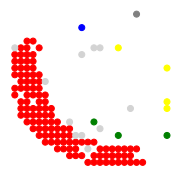

In [22]:
import numpy as np
from neighbors import assign_membership
df = assign_membership(mousewt_ccs, mouse.meta)
red_spots = df.loc[df.cluster=="red",:].index.tolist()
rand_spots = np.random.choice(df.loc[df.cluster!="red",:].index.tolist(),20, replace=False).tolist()
df1 = df.loc[red_spots+rand_spots,:]
plt.figure(figsize=(3,3))
plt.scatter(x=df1.x.to_numpy(), y=df1.y.to_numpy(), c=df1.cluster.tolist())
plt.gca().invert_yaxis()
plt.axis("off")

In [23]:
# f, axs = plt.subplots(ncols=3, nrows=3, figsize=(11, 9))
# eps = [0.5, 0.6, 0.7] # evaluating 3 parameters
# mouse_df, mel2_df = None,None
# # Figure 2a
# for i in range(3):
#     ep = eps[i] # Get region assignment for each of the epsilon value
#     mousewt_ccs = neighbors.spatialCCs(mouse.nodes, mouse.cormat, ep, merge=0)
#     df = neighbors.assign_membership(mousewt_ccs, mouse.meta)
#     ### The color tuning in the following lines of code won't affect the results
#     ### but to make the visualization colormap similar to the manual annotation
#     df.loc[df["size"] == 1,"cluster"] = "lightgray"
#     if ep == 0.5:
#         df.loc[df["cluster"] == "orange", "cluster"] ="cyan"
#         df.loc[df["cluster"] == "yellow", "cluster"] ="orange"
#     if ep == 0.6:
#         df.loc[df["cluster"] == "cyan", "cluster"] ="skyblue"
#         df.loc[df["cluster"] == "yellow", "cluster"] ="cyan"
#         df.loc[df["cluster"] == "red", "cluster"] ="black"
#         df.loc[df["cluster"] == "orange", "cluster"] ="red"
#         df.loc[df["cluster"] == "black", "cluster"] ="orange"
#         df.loc[df["cluster"] == "green", "cluster"] ="pink"
#     if ep == 0.7:
#         df.loc[df["cluster"] == "purple", "cluster"] ="pink"
#         df.loc[df["cluster"] == "cyan", "cluster"] ="skyblue"
#         df.loc[df["cluster"] == "blue", "cluster"] ="cyan"
#         df.loc[df["cluster"] == "orange", "cluster"] ="magenta"
#         df.loc[df["cluster"] == "yellow", "cluster"] ="orange"
#         df.loc[df["cluster"] == "magenta", "cluster"] ="yellow"
#     if ep == 0.8:
#         df.loc[df["cluster"] == "cyan", "cluster"] ="magenta"
#         df.loc[df["cluster"] == "green", "cluster"] ="cyan"
#         df.loc[df["cluster"] == "pink", "cluster"] ="green"
#         df.loc[df["cluster"] == "magenta", "cluster"] ="pink"
#         df.loc[df["cluster"] == "yellow", "cluster"] ="skyblue"
#         df.loc[df["cluster"] == "blue", "cluster"] ="yellow"
    
#     axs[1,i].scatter(x=df.x.to_numpy(), y=df.y.to_numpy(), c=df.cluster.tolist(), s=10)
#     if ep == 0.7:
#         axs[1,i].set_title("Epsilon=%.1f" %ep, color="red", fontweight='bold',style='italic')
#         mouse_df = df.copy()
#     else:
#         axs[1,i].set_title("Epsilon=%.1f" %ep, color="black", style='italic')
#     axs[1,i].invert_yaxis()
#     axs[1,i].axis("off")
    
# # Figure 2b 
# for i in range(3):
#     ep = eps[i]
#     mel2_ccs = neighbors.spatialCCs(melanoma.nodes, melanoma.cormat, ep, merge=0)
#     df = neighbors.assign_membership(mel2_ccs, melanoma.meta)
#     ### The color tuning in the following lines of code won't affect the results
#     ### but to make the visualization colormap similar to the manual annotation
#     df.loc[df.cluster == "black", "cluster"] = "magenta"
#     df.loc[df.cluster == "red", "cluster"] = "black"
#     df.loc[df.cluster == "yellow", "cluster"] = "red"
#     df.loc[df.cluster == "orange", "cluster"] = "yellow"
#     df.loc[df["size"] == 1, "cluster"] = "lightgray"
#     axs[0,i].scatter(x=df.x.to_numpy(), y=df.y.to_numpy(), c=df.cluster.tolist(), s=10)
#     if ep == 0.6:
#         axs[0,i].set_title("Epsilon=%.1f" %ep, color="red", fontweight='bold',style='italic')
#         mel2_df = df.copy()
#     else:
#         axs[0,i].set_title("Epsilon=%.1f" %ep, color="black", style='italic')
#     axs[0,i].invert_yaxis()
#     axs[0,i].axis("off")